# Sequence to Sequence (Seq2Seq)

- 자연어 처리에서 기존의 일반적인 판별 모델(NLU모델, RNN계열 등)은 문장 내 단어들을 각 Node들이 처리해 하나의 결과를 계산
- Seq2Seq: 입력된 단어 Sequence를 이용해, 하나의 나열된 Sequence를 출력하는 구조를 만들어 학습을 수행
- Seq2Seq의 활용
    - 기계 번역/챗봇/문장요약/STT
    
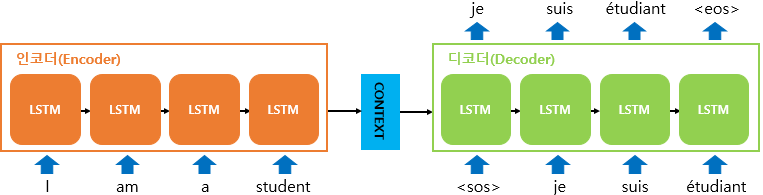

- Seq2Seq는 크게 두 가지 구조로 구성 (두 개의 RNN 구조)
    - Encoder
        - Input Sequence를 받아 문장을 특정 Vector로 변환하는 구조
        - 입력값의 정보를 각 Node가 가지고 있음
    - Decoder
        - Encoder로 전달받은 Vector를 이용해 출력 Sequnce를 생성
    - Context Vector
        - Encoder에 의해 하나의 문장이 변환된 Matrix

- 작동 순서
    1. 입력 문장(Input Sequence)은 단어 토큰화를 통해 단어 단위로 쪼갬
    2. 각 단어 토큰을 RNN Node(LSTM) 입력
    3. 마지막 Node에서 계산된 Context Vector를 Decoder로 건냄
    4. Decoder는 앞서 받은 Context Vector를 첫 번째 Hidden Node에 넣어 처리
    5. Decoder는 초기 입력 문장(Input Sequence)의 시작을 의미하는 심볼 'SOS' 값을 넣어 처리 (Start of Sequence)
    6. 이후에 문장을 이어 받으면서, 다음에 등장할 확률이 높은 단어를 예측
    7. 'EOS' 토큰 (End of Sequence)이 등장하거나, 또는 문장의 최대 길이까지 반복하여, 단어 예측을 수행 ( 지속적으로 단어 토큰을 Node에 넣어 다음 단어를 예측)
    8. 학습은 SOS에서 시작해 EOS까지 단어가 나올 때까지 모델의 단어들을 예측하게 끔 학습

In [60]:
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
import numpy as np

In [61]:
#텍스트 파일을 호출
with open('kor.txt', encoding='UTF-8') as file:
    text1 = file.read().split('\n')

In [62]:
# text1
# 입력 받을 영어 데이터와 학습시킬 한국어 데이터를 처리하는 공간
input_texts = [] # 영어 문장 리스트
target_texts = [] # 한국어 문장 리스트
# 영어 단어 세트 (중복된 알파벳이나 한글 글자를 제외하고 고유값만 지정하기 위함)
# Text -> Seq (단어를 숫자로 표현하기 위해 단어-숫자 사전을 구성하기 위한 자료구조)
input_char_list = set()
target_char_list = set()

In [63]:
text1 # \t : Tab 키를 기준으로 데이터가 분할되어 있음

['Go.\t가.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8363271 (Eunhee)',
 'Hi.\t안녕.\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #8355888 (Eunhee)',
 'Run!\t뛰어!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #8355891 (Eunhee)',
 'Run.\t뛰어.\tCC-BY 2.0 (France) Attribution: tatoeba.org #4008918 (JSakuragi) & #8363273 (Eunhee)',
 'Who?\t누구?\tCC-BY 2.0 (France) Attribution: tatoeba.org #2083030 (CK) & #6820074 (yesjustryan)',
 'Wow!\t우와!\tCC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #8355878 (Eunhee)',
 'Duck!\t숙여!\tCC-BY 2.0 (France) Attribution: tatoeba.org #280158 (CM) & #11106942 (intertime)',
 'Fire!\t쏴!\tCC-BY 2.0 (France) Attribution: tatoeba.org #1829639 (Spamster) & #8355899 (Eunhee)',
 'Help!\t도와줘!\tCC-BY 2.0 (France) Attribution: tatoeba.org #435084 (lukaszpp) & #8355885 (Eunhee)',
 'Hide.\t숨어.\tCC-BY 2.0 (France) Attribution: tatoeba.org #8907581 (CK) & #11106940 (intertime)',
 'Jump!\t점프!\tCC-BY 2.0 (France) A

In [64]:
for line in text1[ :3000]:
    # 문장을 SOS와 EOS를 넣어 처리
    # 처리 단계에서 오류를 방지하기 위한 try/except 구문
    try:
        # Tab키를 기준으로 각 문장을 구분
        input_txt, target_txt, _ = line.split('\t')
        # Target Text(한국어 문장)에 <SOS>와 <EOS> 태그를 부착
        target_txt_seq = '\t' + target_txt+'\n'
        # 앞서 처리한 문장을 반복문에 의해 영어 리스트와 한국어 리스트에 문장을 추가
        input_texts.append(input_txt)
        target_texts.append(target_txt_seq)
    except Exception as e:
        print(line, e)
        continue
    # 분할한 모든 문장에서 고유한 단어(알파벳과 한글 철자)를 뽑아 셋으로 선언
    for char in input_txt: # 영어에 대해 한 문장씩 입력
        input_char_list.add(char)
    for char in target_txt_seq: # 영어에 대해 한 문장씩 입력
        target_char_list.add(char)

In [65]:
# 문자 사전을 만들기 위해 앞서 수집된 철자 세트를 리스트로 변환
input_characters = sorted(list(input_char_list))
target_characters = sorted(list(target_char_list))

# 전체 고유 단어(알파벳, 철자)의 개수를 확인
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
# 전체 문장 중 가장 문장이 긴 문장의 단어 수를 확인 (Padding 작업을 수행)
max_encoder_seq_length = max([len(x) for x in input_texts]) # 영어문장 최대 길이
max_decoder_seq_length = max([len(x) for x in target_texts]) # 한글문장 최대 길이

In [66]:
max_encoder_seq_length

26

In [67]:
max_decoder_seq_length

30

In [68]:
# 단어 사전을 구성하기 위해, 각 단어를 하나의 정수로 변환
# 영어 알파벳-숫자 사전
input_token_index = dict([(k,i) for i, k in enumerate(input_characters)])
# 한국어 철자-숫자 사전
target_token_index = dict([(k,i) for i, k in enumerate(target_characters)])

In [69]:
target_token_index

{'\t': 0,
 '\n': 1,
 ' ': 2,
 '!': 3,
 '"': 4,
 '(': 5,
 ')': 6,
 ',': 7,
 '.': 8,
 '0': 9,
 '1': 10,
 '2': 11,
 '3': 12,
 '4': 13,
 '5': 14,
 '6': 15,
 '7': 16,
 ':': 17,
 '?': 18,
 'T': 19,
 'V': 20,
 '~': 21,
 '가': 22,
 '각': 23,
 '간': 24,
 '갇': 25,
 '갈': 26,
 '감': 27,
 '갑': 28,
 '값': 29,
 '갔': 30,
 '강': 31,
 '갖': 32,
 '같': 33,
 '갛': 34,
 '개': 35,
 '갰': 36,
 '걀': 37,
 '걔': 38,
 '거': 39,
 '걱': 40,
 '건': 41,
 '걷': 42,
 '걸': 43,
 '검': 44,
 '겁': 45,
 '것': 46,
 '게': 47,
 '겐': 48,
 '겠': 49,
 '겨': 50,
 '격': 51,
 '견': 52,
 '결': 53,
 '겼': 54,
 '경': 55,
 '곁': 56,
 '계': 57,
 '고': 58,
 '곤': 59,
 '곧': 60,
 '골': 61,
 '곱': 62,
 '곳': 63,
 '공': 64,
 '과': 65,
 '관': 66,
 '괜': 67,
 '괴': 68,
 '굉': 69,
 '교': 70,
 '구': 71,
 '국': 72,
 '군': 73,
 '굴': 74,
 '굶': 75,
 '굽': 76,
 '궁': 77,
 '권': 78,
 '귀': 79,
 '그': 80,
 '극': 81,
 '근': 82,
 '글': 83,
 '금': 84,
 '급': 85,
 '긋': 86,
 '긍': 87,
 '기': 88,
 '긴': 89,
 '길': 90,
 '김': 91,
 '깊': 92,
 '까': 93,
 '깎': 94,
 '깐': 95,
 '깔': 96,
 '깜': 97,
 '깡': 98,
 '깨': 99,
 '꺼': 10

In [70]:
# 각 문장을 변환된 정수로 채워넣을 Matrix 틀을 먼저 생성 (0값 채워 지게끔 구성)
# 입력 영어 문장이 담길 Matirx 구조
encoder_input_data = np.zeros(
                    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
                    dtype = 'float32')

In [71]:
# 입력 한국어 문장이 담길 Matirx 구조
decoder_input_data = np.zeros(
                    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
                    dtype = 'float32')

In [72]:
# 출력 한국어 문장이 담길 Matirx 구조
decoder_target_data = np.zeros(
                            (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
                            dtype = 'float32')

In [73]:
encoder_input_data.sum()

0.0

In [74]:
# 구성된 Matix에 각 단어에 매칭되는 숫자를 입력
# 영어 문장과 한국어 문장을 각각 가져와 동시에 숫자를 각 Matix에 입력
for i , (input_txt, target_txt) in enumerate(zip(input_texts, target_texts)):
    # 영어 문장에 대해 해당 단어를 숫자형태로 변환
    for k, char in enumerate(input_txt):
        encoder_input_data[i, k, input_token_index[char]] = 1. # 해당하는 곳에 1값 넣기
    # 한국어 문장에 대해 해당 철자를 숫자 형태로 변환
    for k, char in enumerate(target_txt):
        decoder_input_data[i, k, target_token_index[char]] = 1.
        if k > 0: # 문장의 단어 수가 0보다 크면
            decoder_target_data[i, k-1, target_token_index[char]] = 1.

In [75]:
encoder_input_data.sum()

54497.0

In [93]:
# 학습시간과 컴퓨터 성능을 고려해 간소화하여 학습
# (실제 성능이 어느정도 충족되기 위한 파라미터 / 5000문장을 이용해 학습할 시)
batch_size = 32 # 훈련배치 크기 (64이상)
epochs = 20 # 훈련 반복 수 (500회)
node_num = 64 # 인코딩 공간의 노드 수 (1024개 이상)

In [94]:
# 인코더 신경망 구축
# 영어 문장이 들어가 LSTM 모델에 의해 학습이 수행
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(node_num, return_state=True)

# state_h : 마지막 Hidden State
# state_c : 마지막 LSTM의 Cell State
encoder_output, state_h, state_c = encoder(encoder_inputs)

# 인코더가 입력 Seq를 처리한 후에 얻은 정보를
# encoder_state변수로 지정해 decoder로 전달
encoder_states = [state_h, state_c] # Decoder가 이를 기반으로 출력 Seq를 생성

In [97]:
# 디코더 신경망 구축
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(node_num, return_sequences=True, return_state=True)
# return_sequences=True: 각 순서 단계에서 Seq 전체의 출력을 반환
# return_state=True: 마지막 상태(Hidden State, Cell State)가 함께 반환

# 앞서 처리된 Encoder State의 정보를 바탕으로 초기상태를 설정
decoder_output, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# soft max 함수를 활}용해 출력값을 계산
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_output = decoder_dense(decoder_output)

In [98]:
# Seq2Seq 구성
model = Model([encoder_inputs,decoder_inputs], decoder_output)
model.compile(optimizer= 'adam', loss= 'categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
         batch_size=batch_size,
         epochs=epochs,
         validation_split=0.2)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 2.2608 - val_loss: 2.3453
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 1.7399 - val_loss: 2.3321
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 1.7091 - val_loss: 2.3177
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 1.6968 - val_loss: 2.3063
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 1.6817 - val_loss: 2.2934
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 1.6903 - val_loss: 2.2835
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 1.6846 - val_loss: 2.2731
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 1.6622 - val_loss: 2.2601
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 1.6712 - val_loss: 2.2509
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 1.6701 - val_loss: 2.2409
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 1.6334 - val_loss: 2.2322
Epoch 12/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 1.6

In [114]:
# NLU 이후의 NLG 파트를 구성

# 학습 과정에서 구성한 인코더의 입력과 상태를 기반으로 하는 새로운 모델을 구성
encoder_model = Model(encoder_inputs, encoder_states)

# 디코더의 LSTM 레이어에 전달될 초기 상태를 정의
decoder_state_input_h = Input(shape=(node_num, )) # Hidden State 초기값
decoder_state_input_c = Input(shape=(node_num, )) # Cell State 초기값
# 디코더의 초기 정보를 구성
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 구성된 Input Node를 이용하여, Decoder의 Layer 구성
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs,
                                                 initial_state=decoder_states_inputs)

# 다음 Step으로 전달 될 상태를 지정 
decoder_states = [state_h, state_c]

# SoftMax함수를 이용해 출력을 계산
decoder_outputs = decoder_dense(decoder_outputs)

# 다음 단계의 토큰을 예측하고, 다음 문장을 생성하기 위한 새로운 상태를 구성
decoder_model = Model([decoder_inputs]+decoder_states_inputs,
                [decoder_outputs]+decoder_states)

In [115]:
# Decoder가 계산한 결과를 이용해, Seq2Text (숫자를 문자로) 변환하는 작업을 수행
reverse_input_char_index = dict((i,char) for char,i in input_token_index.items())
reverse_target_char_index = dict((i,char) for char,i in target_token_index.items())

In [118]:
# 입력 문장이 들어왔을 때, 해당 문장을 번역하는 함수를 구성
def decode_sequence(input_seq):
    # 입력받은 Sequence를 이용해, Encoder에 집어넣어 Context Vector를 구축
    state_value = encoder_model.predict(input_seq, verbose=0) # verbose = 0 /모델 진행 사항 생략
    
    # Decoder의 초기 Sequence를 생성 /모든 토큰값에 대해 0으로 채워진 배열을 구성
    target_seq = np.zeros((1,1, num_decoder_tokens))
    # 시작 토큰 (SOS)의 위치를 1로 설정하여 Decoder가 예측을 시작할 부분을 지정
    target_seq[0,0, target_token_index['\t']] = 1
    
    # Decoding 실시
    # Decoding 종료조건 : 
        # 1. <EOS> 토큰을 만날 때 문장의 생성 종료
        # 2. 사용자가 사전에 지정한 문장의 길이가 벗어나는 경우 종료
    # 종료조건을 판별하는 변수를 선언
    stop_cond = False
    # 생성될 문자를 담아 줄 변수를 선언
    decoder_sentence = ''
    
    # 위의 조건을 만족할 때까지 단어 생성을 반복해서 수행
    while not stop_cond: # True값이 오게되면 while문이 종료됨
        # 디코더의 Layer 정보를 이용해 Output Token cnffur
        output_token,h,c = decoder_model.predict([target_seq] + state_value,
                                                 verbose=0)
        # 가장 확률이 높게 나온 계산된 숫자값을 확인
        sampled_token_index = np.argmax(output_token[0, -1, :])
        
        # 해당 Index를 문자로 변환
        sampled_char = reverse_target_char_index[sampled_token_index]
        # 한개씩 출력된 단어를 문장으로 이어붙이기
        decoder_sentence += sampled_char
        
        if (sampled_char=='\n' or len(decoder_sentence)>max_decoder_seq_length):
            stop_cond = True
            
        # 종료가 되지 않았을 시, 다음 단어를 예측하기 위해, 일부 변수 초기화
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0,0,sampled_token_index] = 1
        state_value = [h,c]
        
    # 종료 조건에 의해 반복이 멈추면, 생성된 문장을 출력
    return decoder_sentence

In [119]:
# 기존 사전(kor.txt)에 있는 단어를 이용해 , 번역결과를 확인
for seq_index in range(5): # 5개 문장을 확인
    input_seq = encoder_input_data[seq_index : seq_index+1]
    result = decode_sequence(input_seq)
    print('입력 문장 : ', input_texts[seq_index])
    print('출력 문장 : ', result)
    print('--------------')

입력 문장 :  Go.
출력 문장 :  그                              
--------------
입력 문장 :  Hi.
출력 문장 :  톰은                             
--------------
입력 문장 :  Run!
출력 문장 :  그                              
--------------
입력 문장 :  Run.
출력 문장 :  그                              
--------------
입력 문장 :  Who?
출력 문장 :  그                              
--------------


---

# 개별미션

- 아래의 미션을 Jupyter Notebook으로 풀이 후, [File] - [Download as]에 [HTML (.html] 로 저장하여 메일로 송부해주세요.
- 제출 양식 : [하나은행_데이터] 홍길동_개별 미션 (13주차 1일)
- '37_Data.xlsx'를 불러와 아래의 분석을 실시

In [163]:
import pandas as pd

In [164]:
df1 = pd.read_excel('37_Data.xlsx')

In [165]:
df1.columns

Index(['NO', '분류', 'VOC', '대응우선순위'], dtype='object')

---

해당 데이터는 모 카드사에서 고객들이 전화상담을 진행하고 나온 고객 VOC 데이터 이다.

1. '분류'에서 '불만'과'칭찬' VOC에 대해, 고객 VOC를 입력했을 때, 해당 VOC가 '불만'에 해당하는 것인지 '칭찬'에 해당하는 것인지 분류하는 모델을 RNN 계열의 모델을 선택해 생성하시오.

In [166]:
df1['재분류'] = df1['분류'].apply(lambda x: '불만' if '불만' in x else ('칭찬' if '칭찬' in x else None))
df1['재분류'].value_counts()

재분류
불만    512
칭찬    481
Name: count, dtype: int64

In [167]:
df1 = df1.dropna()

In [168]:
# 칭찬은 0 / 불만은 1으로 분류
df1['Target'] =  df1['재분류'].replace('칭찬',0).replace('불만',1)
df1['Target'].value_counts()

Target
1    512
0    481
Name: count, dtype: int64

In [169]:
Y = df1['Target']
X = df1['VOC']

In [170]:
Y.isnull().sum()

0

In [171]:
from sklearn.model_selection import train_test_split

In [172]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3,
                                                   random_state=1234)

In [162]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [148]:
# 텍스트가 문장표현으로 처리되는 함수를 구성
def text_preprocessing(X):
    tokenizer = Tokenizer(num_words=100)
    tokenizer.fit_on_texts(X)
    seq1 = tokenizer.texts_to_sequences(X)
    return pad_sequences(seq1, maxlen=20)

In [149]:
from keras.layers import SimpleRNN
from keras.layers import Embedding
from keras.layers import Dense
from keras.models import Sequential

In [173]:
X_train_NN = text_preprocessing(X_train)
X_test_NN = text_preprocessing(X_test)

In [174]:
# RNN 모델 구성
model_RNN = Sequential()
model_RNN.add(Embedding(10000, 8))
model_RNN.add(SimpleRNN(32))
model_RNN.add(Dense(1, activation='sigmoid'))
model_RNN.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy'])
model_RNN.fit(X_train_NN, Y_train, epochs=10, batch_size=32,
             validation_split=0.2)

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4943 - loss: 0.6888 - val_accuracy: 0.4820 - val_loss: 0.6720
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6328 - loss: 0.6642 - val_accuracy: 0.7266 - val_loss: 0.6410
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7186 - loss: 0.6333 - val_accuracy: 0.7914 - val_loss: 0.5998
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7610 - loss: 0.5892 - val_accuracy: 0.7986 - val_loss: 0.5416
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7555 - loss: 0.5355 - val_accuracy: 0.8058 - val_loss: 0.4912
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7785 - loss: 0.4934 - val_accuracy: 0.8201 - val_loss: 0.4661
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7690 - loss: 0.4536 - val_accuracy: 0.8273 - val_loss: 0.4256
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7913 - loss: 0.4098 - val_accuracy: 0.8345 - val_loss:

In [175]:
def threshold(result):
    if result >= 0.5:
        return 1
    return 0

In [176]:
model_RNN.predict(X_train_NN)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


array([[0.24071093],
       [0.05135577],
       [0.567826  ],
       [0.00312914],
       [0.82282394],
       [0.9936147 ],
       [0.06104048],
       [0.88419914],
       [0.567826  ],
       [0.567826  ],
       [0.6452949 ],
       [0.09614686],
       [0.79678434],
       [0.02536386],
       [0.02536386],
       [0.25653285],
       [0.94353867],
       [0.76655513],
       [0.98875225],
       [0.567826  ],
       [0.567826  ],
       [0.567826  ],
       [0.71152294],
       [0.384775  ],
       [0.6555471 ],
       [0.9647661 ],
       [0.567826  ],
       [0.56266695],
       [0.9737931 ],
       [0.00595486],
       [0.8501432 ],
       [0.01268108],
       [0.540666  ],
       [0.00595486],
       [0.1966277 ],
       [0.9725625 ],
       [0.567826  ],
       [0.8614707 ],
       [0.00602374],
       [0.567826  ],
       [0.8510233 ],
       [0.0940702 ],
       [0.567826  ],
       [0.567826  ],
       [0.01268108],
       [0.9629201 ],
       [0.00918128],
       [0.822

In [177]:
Y_train_pred = pd.Series(model_RNN.predict(X_train_NN).flatten()).apply(threshold)
Y_test_pred = pd.Series(model_RNN.predict(X_test_NN).flatten()).apply(threshold)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


In [178]:
from sklearn.metrics import classification_report

print(classification_report(Y_train, Y_train_pred))
print(classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

           0       0.95      0.66      0.78       352
           1       0.73      0.97      0.83       343

    accuracy                           0.81       695
   macro avg       0.84      0.81      0.81       695
weighted avg       0.84      0.81      0.81       695

              precision    recall  f1-score   support

           0       0.64      0.53      0.58       129
           1       0.69      0.78      0.73       169

    accuracy                           0.67       298
   macro avg       0.67      0.66      0.66       298
weighted avg       0.67      0.67      0.67       298



---

2. 생성한 모델에 아래의 VOC를 입력했을 때, 해당 VOC가 어디로 분류 되는지 확인하시오.

고객 VOC : 대출 상환을 앱에서 쉽게 할 수 있도록 보완 해주세요 상환이 너무 어려워 앱 쓰다가 정말 짜증나요

In [194]:
text = '대출 상환을 앱에서 쉽게 할 수 있도록 보완 해주세요 상환이 너무 어려워 앱 쓰다가 정말 짜증나요'

In [195]:
text3 = text_preprocessing(text)

In [197]:
ex2_pred = model_RNN.predict(text3)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [206]:
prediction = threshold(ex2_pred[0][0])

if prediction == 1:
    print("불만입니다.")
else:
    print("칭찬입니다.")

불만입니다.


----

3. '분류'에서 DS카드에 해당하는 VOC들만 뽑아, 명사만 추출하여 '무이자할부'라는 단어가 등장할 때, 가장 유사도가 높은 단어들을 확인하시오.

In [182]:
df2 = df1[df1['분류'].str.contains('DS카드')]

In [213]:
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec

In [185]:
# 명사 추출 함수 정의
def extract_nouns(text):
    okt = Okt()
    nouns = okt.nouns(text)
    return ' '.join(nouns)

In [186]:
text3 = df2['VOC'].dropna().str.split().tolist()

In [189]:
word2vec_model = Word2Vec(sentences=text3, vector_size=100,
                          window=5, sg=1, min_count=1, workers=4)

In [190]:
word2vec_model.wv.most_similar('무이자할부')

[('통화연결은', 0.25732943415641785),
 ('보내세요', 0.25423160195350647),
 ('해요', 0.2493661344051361),
 ('상담사로', 0.24276967346668243),
 ('연회비가.너무비싸요', 0.23203493654727936),
 ('문자를', 0.23023401200771332),
 ('있습니다.', 0.22547075152397156),
 ('찾지못해', 0.22210822999477386),
 ('개선해야', 0.2187902331352234),
 ('전에', 0.2141106277704239)]

---

4. 고객 '대응우선순위' 10위 권 내 VOC들에 대해, 명사만 추출하여 '토픽 모델링'을 실시, 주제 문장 3문장을 확인하시오.

In [211]:
from gensim import corpora, models
from nltk.tokenize import word_tokenize, sent_tokenize

In [199]:
df1['대응우선순위'].unique()

array([ 5, 33, 24,  4, 29, 42, 41, 37, 35, 34, 32, 31, 30, 26, 25,  2, 15,
       14,  1, 23, 19, 18, 13, 12, 11,  7])

In [202]:
df4 = df1[df1['대응우선순위']<=10]

In [208]:
text = ' '.join(df4['VOC'].dropna())

In [209]:
# 문장분리
document1 = [x for x in sent_tokenize(text)]

In [214]:
okt = Okt()

In [216]:
stopword_list=[]

In [217]:
# 불용어 처리 및 명사추출
doc_N1 = [[y for y in okt.nouns(x) if y not in stopword_list] for x in document1]

In [218]:
# 단어 사전 필요
doc_dict1 = corpora.Dictionary(doc_N1)

In [219]:
# 코퍼스
corpus1 = [doc_dict1.doc2bow(x) for x in doc_N1]

In [220]:
# LDA
lda_model = models.LdaModel(corpus1, num_topics=3, id2word=doc_dict1,
                            passes=15)

In [221]:
lda_model.print_topics()

[(0,
  '0.090*"상담" + 0.083*"시간" + 0.066*"연결" + 0.065*"통화" + 0.044*"대기" + 0.025*"상담사" + 0.021*"고객" + 0.019*"설명" + 0.017*"때" + 0.017*"직원"'),
 (1,
  '0.034*"답변" + 0.033*"상담" + 0.030*"고객" + 0.021*"입장" + 0.020*"기분" + 0.020*"직원" + 0.018*"응대" + 0.014*"이자" + 0.014*"좀" + 0.011*"교육"'),
 (2,
  '0.262*"상담" + 0.088*"감사" + 0.077*"친절" + 0.013*"응대" + 0.013*"직원" + 0.012*"고객" + 0.011*"처리" + 0.010*"주말" + 0.010*"말투" + 0.009*"더"')]

---

5. '대응우선순위'가 10위권 내 VOC와 아닌 VOC 에 대해 고객 '불만/칭찬' 여부의 유의미한 차이가 있는지 가설검정을 실시하시오.

In [222]:
#cond1 = df1['대응우선순위']<=10
#df5_1 = df1.loc[cond1] # 10위권 내인 VOC
#df5_2 = df1.loc[~cond1]

In [226]:
from scipy.stats import chi2_contingency

In [227]:
# 귀무: 대응우선순위'가 10위권 내 VOC와 아닌 VOC 에 대해 
#      고객 '불만/칭찬'여부의 유의미한 차이 없음
# 대립: 대응우선순위'가 10위권 내 VOC와 아닌 VOC 에 대해 
#      고객 '불만/칭찬'여부의 유의미한 차이 있음
cross1 = pd.crosstab(df1['재분류'], df1['대응우선순위'] <= 10)
chi2_contingency(cross1)
# P.value < 0.05 / 대립 참
# 대응우선순위'가 10위권 내 VOC와 아닌 VOC 에 대해 
# 고객 '불만/칭찬' 여부의 유의미한 차이 있음

Chi2ContingencyResult(statistic=14.625520255291462, pvalue=0.00013112677331605097, dof=1, expected_freq=array([[201.08761329, 310.91238671],
       [188.91238671, 292.08761329]]))

In [230]:
df1[df1['재분류']=='불만']

,NO,분류,VOC,대응우선순위,재분류,Target
0,1,불만>고객서비스>상담시스템,상담직원과 빠른연결했슴좋겠어요,5,불만,1
1,2,불만>고객서비스>상담시스템,안기다리고. 빨리상담되었음좋겠다,5,불만,1
2,3,불만>고객서비스>상담시스템,너무 오래기다리고 상담이 늦어져요,5,불만,1
3,4,불만>고객서비스>상담시스템,상담직원과 통화가 매우 힘들다,5,불만,1
4,5,불만>고객서비스>상담시스템,상담받으려면오래기다리는게불편함,5,불만,1
...,...,...,...,...,...,...
513,4938,불만>DS카드>혜택,포인트 적립이 더높아지면...,25,불만,1
514,4939,불만>DS카드>혜택,카드 사용시 포인트 적립이 적다고 생각됨,25,불만,1
515,4940,불만>DS카드>혜택,많은포인트혜택을주세요,25,불만,1
969,9705,불만>기타,00카드는 상담하면 기분이 나뻐집니다 ㅋDS은 좋아요!!,42,불만,1
